In [1]:
import matplotlib.pyplot as plt
import os
import shutil
import zipfile
import glob
import cv2
import tensorflow as tf
import numpy as np
import pandas as pd
import random
import pydot
import graphviz
# import pydotplus

In [2]:
from PIL import Image

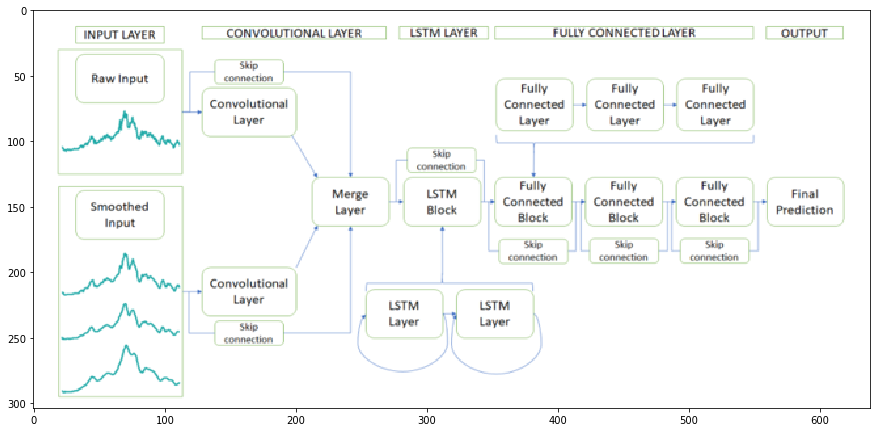

In [3]:
img = Image.open('C:/Users/begas/Desktop/ficture.png')
fig, ax = plt.subplots(figsize = (15,10))
ax.imshow(img)

In [4]:
# Input Layer 0 ===============================================================================================================
# input shape : (nTimeSteps, nFeatures)
layer_input_0 = tf.keras.Input(shape = (65,10), name = "input0") # Input for Merge Layer -> skip Conv Layer

# Conv 1D Layer ======================================================================
Conv_layer_0  = tf.keras.layers.Conv1D(64, kernel_size = 2, padding='same', name = 'Input0_Conv0_Conv1D')(layer_input_0)
Conv_layer_0  = tf.keras.layers.Activation('relu', name = 'Input0_Conv0_Activation')(Conv_layer_0)
# Conv_layer_0  = tf.keras.layers.MaxPooling1D(pool_size = 2, name = 'Input0_Conv0_Pool')(Conv_layer_0)

# for idx,conv_filter in enumerate([64,128]):
#     Conv_layer_0  = tf.keras.layers.Conv1D(conv_filter, kernel_size = 3, padding='same', name = f'Input0_Conv{str(idx+1)}_Conv1D')(Conv_layer_0)
#     Conv_layer_0  = tf.keras.layers.BatchNormalization(name = f'Input0_Conv{str(idx+1)}_BatchNormal')(Conv_layer_0)
#     Conv_layer_0  = tf.keras.layers.Activation('relu',name = f'Input0_Conv{str(idx+1)}_Activation')(Conv_layer_0)
# #     Conv_layer_0  = tf.keras.layers.MaxPooling1D(pool_size = 2)(Conv_layer_0)

# Input Layer 1 ===============================================================================================================
layer_input_1 = tf.keras.Input(shape = (65,10), name = "input1") # Input for Merge Layer -> skim Conv Layer

# Conv 1D Layer ======================================================================
Conv_layer_1  = tf.keras.layers.Conv1D(64, kernel_size = 2, padding='same', name = 'Input1_Conv0_Conv1D')(layer_input_1)
Conv_layer_1  = tf.keras.layers.Activation('relu', name = 'Input1_Conv0_Activation')(Conv_layer_1)
# Conv_layer_1  = tf.keras.layers.MaxPooling1D(pool_size = 2, name = 'Input1_Conv0_Pool')(Conv_layer_1)

# for idx,conv_filter in enumerate([64,128]):
#     Conv_layer_1  = tf.keras.layers.Conv1D(conv_filter, kernel_size = 3, padding='same', name = f'Input1_Conv{str(idx+1)}_Conv1D')(Conv_layer_1)
#     Conv_layer_1  = tf.keras.layers.BatchNormalization(name = f'Input1_Conv{str(idx+1)}_BatchNormal')(Conv_layer_1)
#     Conv_layer_1  = tf.keras.layers.Activation('relu',name = f'Input1_Conv{str(idx+1)}_Activation')(Conv_layer_1)
#     Conv_layer_1  = tf.keras.layers.MaxPooling1D(pool_size = 2)(Conv_layer_1)

# Merge Layer / input and Conv_layer =================================================
# Merge_layer = tf.keras.layers.average([layer_input_0, Conv_layer])
# Merge_layer = tf.keras.layers.add([layer_input_0, Conv_layer])
Merge_layer_conv = tf.keras.layers.concatenate([layer_input_0, Conv_layer_0,layer_input_1,Conv_layer_1], name = 'Conv_Merge')

# LSTM Layer =========================================================================
LSTM_layer = tf.keras.layers.LSTM(100, return_sequences=True, dropout=0.25, name = 'Lstm_0')(Merge_layer_conv)
LSTM_layer = tf.keras.layers.LSTM(100, return_sequences=True, dropout=0.25, name = 'Lstm_1')(LSTM_layer)

# Fully Connected Layer =============================================================
Merge_layer_Before_fc = tf.keras.layers.concatenate([LSTM_layer,Merge_layer_conv], name = 'Merge_layer_Before_fc0')

for nStack in range(1) :
#     Fc_layer = \
#     tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units = 128, activation = 'linear', name = f'Fc_layer_{str(nStack)}'))(Merge_layer_Before_fc)
    Fc_layer = \
    tf.keras.layers.Dense(units = 100, activation = 'linear', name = f'Fc_layer_{str(nStack)}')(Merge_layer_Before_fc)
    Merge_layer_Before_fc = tf.keras.layers.concatenate([Fc_layer,Merge_layer_Before_fc], name = f'Merge_layer_Before_fc{str(nStack+1)}')
    
# Output Layer =======================================================================
Output_layer = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units = 1, activation = 'linear', name = 'output'))(Merge_layer_Before_fc)  

# Create CNN LSTM Model ==============================================================
cnn_lstm_model = tf.keras.Model([layer_input_0,layer_input_1], Output_layer)

cnn_lstm_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input0 (InputLayer)             [(None, 65, 10)]     0                                            
__________________________________________________________________________________________________
input1 (InputLayer)             [(None, 65, 10)]     0                                            
__________________________________________________________________________________________________
Input0_Conv0_Conv1D (Conv1D)    (None, 65, 64)       1344        input0[0][0]                     
__________________________________________________________________________________________________
Input1_Conv0_Conv1D (Conv1D)    (None, 65, 64)       1344        input1[0][0]                     
______________________________________________________________________________________________

### anaconda plot_model graphviz 설치
```
1. jupyter notebook 종료 후, anaconda prompt를 켜주세요.

2. conda install graphviz를 입력하세요.

3. conda install -c conda-forge python-graphviz를 입력하세요

4. pip install pydot(주피터 내부에서도 설치잘됨)
```



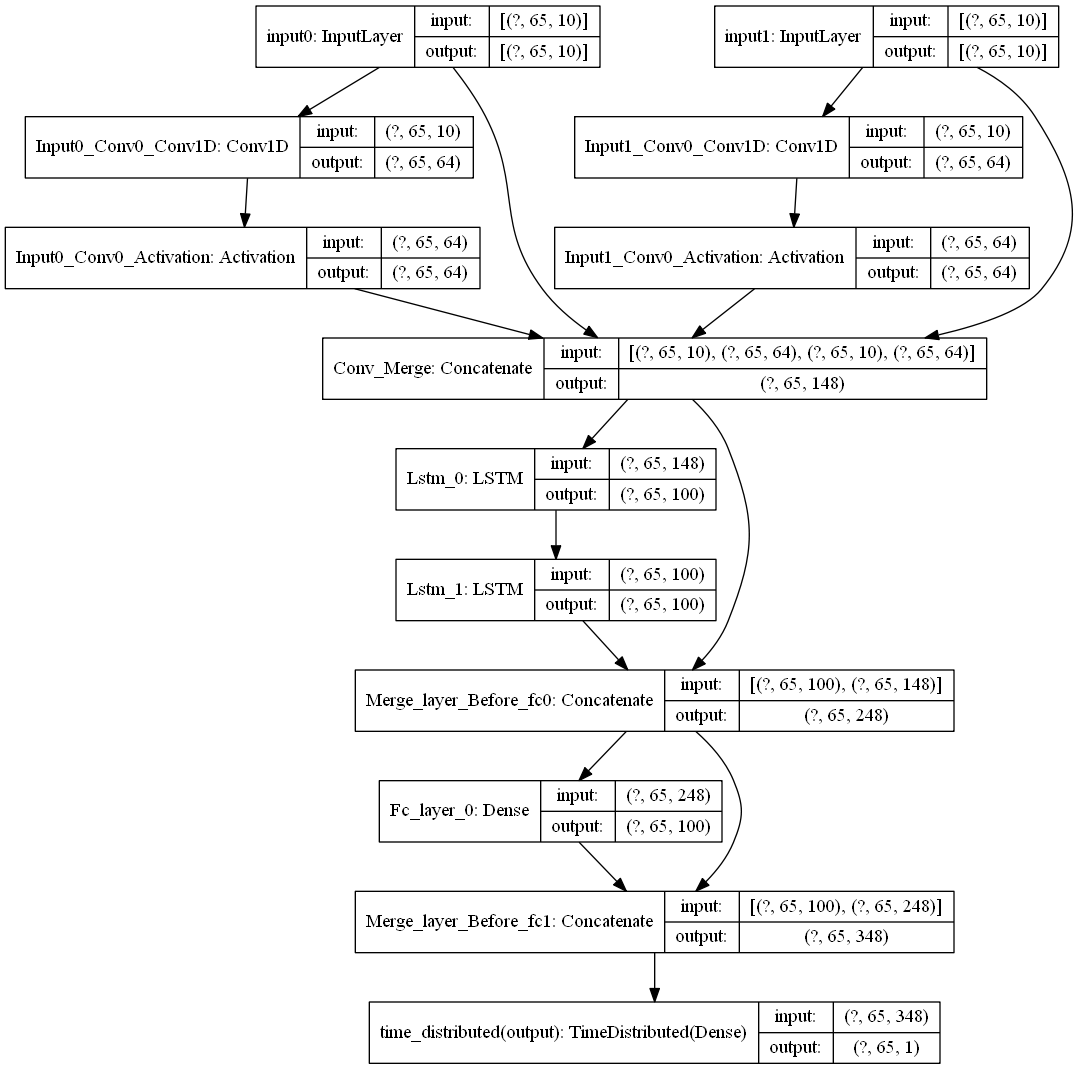

In [5]:
tf.keras.utils.plot_model(cnn_lstm_model, to_file='model_plot1.png', show_shapes=True, show_layer_names=True)

### Conv 1D Layer 설명
```
https://gmnam.tistory.com/274
```


In [6]:
# 각 TimeSeries 변수 별로 kerner_size * 1의 필터가 적용
# example)
# Input = np.array([[0, 0], [3, 6], [4, 7], [5, 8]]) # 2개의 타임시리즈, nTimeSteps = 4, Feature = 2
# df = pd.DataFrame(data=Input, columns=["feature1", "feature2"])
# kernels = np.array([[1,2],[3,4]]) # Feature 만큼의 Kernel 생성
# 각 피쳐별로 Kernel 적용

# 첫번째 피쳐 * 첫번째 커널
# [0,3] * [1,2] = 6
# [3,4] * [1,2] = 11
# [4,5] * [1,2] = 14
# out_1 = [6,11,14]

# 두번째 피쳐 * 두번째 커널
# [0,6] * [3,4] = 24
# [6,7] * [3,4] = 46
# [7,8] * [3,4] = 53
# out_2 = [24,46,53]

# 최종 아웃풋은 각 피쳐에서 커널을 적용한 결과 백터의 합
# [6,11,14] + [24,46,53] = [30,57,67]
# Output = np.array([30, 57, 67])